# Crypto Currency Price Prediction using LSTM

**A cryptocurrency is a digital or virtual currency that is secured by cryptography, which makes it nearly impossible to counterfeit or double-spend. Many cryptocurrencies are decentralized networks based on blockchain technology—a distributed ledger enforced by a disparate network of computers. A defining feature of cryptocurrencies is that they are generally not issued by any central authority, rendering them theoretically immune to government interference or manipulation.**

Sources :- https://www.investopedia.com/terms/c/cryptocurrency.asp
          https://www.sciencedirect.com/science/article/abs/piiS2214212620307535

**A cryptocurrency is a network-based digital exchange medium, where the records are secured using strong cryptographic algorithms such as Secure Hash Algorithm 2 (SHA-2) and Message Digest 5 (MD5). It uses blockchain technology to make the transactions secure, transparent, traceable, and immutable. Due to these properties, the cryptocurrencies have gained popularity in almost all the sectors especially in financial sectors. Though, cryptocurrencies are getting recognition form the approval bodies, but still, the uncertainty and dynamism in their prices risk the investments substantially. Cryptocurrency price prediction has become a trending research topic globally.**

**Many machine learning and deep learning algorithms such as Gated Recurrent Unit (GRU), Neural Networks (NN), and Long short-term memory (LSTM) have been used by the researchers to predict and analyze the factors affecting the cryptocurrency prices. In this paper, a LSTM and GRU-based hybrid cryptocurrency prediction scheme is proposed, which focuses on only two cryptocurrencies, namely Litecoin and Monero. The results depict that the proposed scheme accurately predicts the prices with high accuracy, revealing that the scheme can be applicable in various cryptocurrencies price predictions.**

**The dataset can be downloaded from the CryptoCompare website.**

The dataset contains total of 5 features. The details for them are as follows:

Close Price — It is the market close price for currency for that particular day.

High Price — It is highest price of currency for the day.

Low Price — It is the lowest price for currency for that day.

Open Price — It is market open price for currency for that day.

Volume — The volume of currency that is being in trade for that day.

In [46]:
import json
import requests
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd    
import seaborn as sns
from sklearn.metrics import mean_absolute_error

In [24]:
endpoint = 'https://min-api.cryptocompare.com/data/histoday'
res = requests.get(endpoint + '?fsym=BTC&tsym=EUR&limit=500')
hist = pd.DataFrame(json.loads(res.content)['Data'])

In [25]:
hist

,time,high,low,open,volumefrom,volumeto,close,conversionType,conversionSymbol
0,1580083200,8141.73,7766.65,7797.40,9939.17,7.902302e+07,8071.02,direct,
1,1580169600,8525.61,7889.06,8071.02,14258.93,1.170772e+08,8504.29,direct,
2,1580256000,8563.80,8391.20,8504.29,9424.87,7.992678e+07,8433.14,direct,
3,1580342400,8669.84,8347.96,8433.14,9790.97,8.346938e+07,8613.43,direct,
4,1580428800,8628.21,8329.03,8613.43,9079.70,7.663898e+07,8416.44,direct,
...,...,...,...,...,...,...,...,...,...
496,1622937600,30049.18,29031.88,29304.73,7732.30,2.290899e+08,29472.66,direct,
497,1623024000,30283.24,27427.19,29472.66,14507.28,4.229042e+08,27599.01,direct,
498,1623110400,27980.00,25495.27,27599.01,25751.63,6.917419e+08,27461.12,direct,
499,1623196800,30832.85,26663.06,27461.12,24963.68,7.197754e+08,30711.65,direct,


In [26]:
hist = hist.set_index('time')

In [29]:
hist.index = pd.to_datetime(hist.index , unit = 's')
hist.index

DatetimeIndex(['2020-01-27', '2020-01-28', '2020-01-29', '2020-01-30',
               '2020-01-31', '2020-02-01', '2020-02-02', '2020-02-03',
               '2020-02-04', '2020-02-05',
               ...
               '2021-06-01', '2021-06-02', '2021-06-03', '2021-06-04',
               '2021-06-05', '2021-06-06', '2021-06-07', '2021-06-08',
               '2021-06-09', '2021-06-10'],
              dtype='datetime64[ns]', name='time', length=501, freq=None)

**Dropping the conversion type and conversion symbol as they provide much information.**

In [30]:
target_col = 'close'
hist= hist.drop(columns=['conversionType','conversionSymbol'], axis= 1)
hist

,high,low,open,volumefrom,volumeto,close
time,,,,,,
2020-01-27,8141.73,7766.65,7797.40,9939.17,7.902302e+07,8071.02
2020-01-28,8525.61,7889.06,8071.02,14258.93,1.170772e+08,8504.29
2020-01-29,8563.80,8391.20,8504.29,9424.87,7.992678e+07,8433.14
2020-01-30,8669.84,8347.96,8433.14,9790.97,8.346938e+07,8613.43
2020-01-31,8628.21,8329.03,8613.43,9079.70,7.663898e+07,8416.44
...,...,...,...,...,...,...
2021-06-06,30049.18,29031.88,29304.73,7732.30,2.290899e+08,29472.66
2021-06-07,30283.24,27427.19,29472.66,14507.28,4.229042e+08,27599.01
2021-06-08,27980.00,25495.27,27599.01,25751.63,6.917419e+08,27461.12


**Splitting the dataset in training set (70%) and test set (30%)**

In [31]:
def train_test_split(df, test_size):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

train, test = train_test_split(hist, test_size=0.3)

**Prediction of cryptocurrency price**

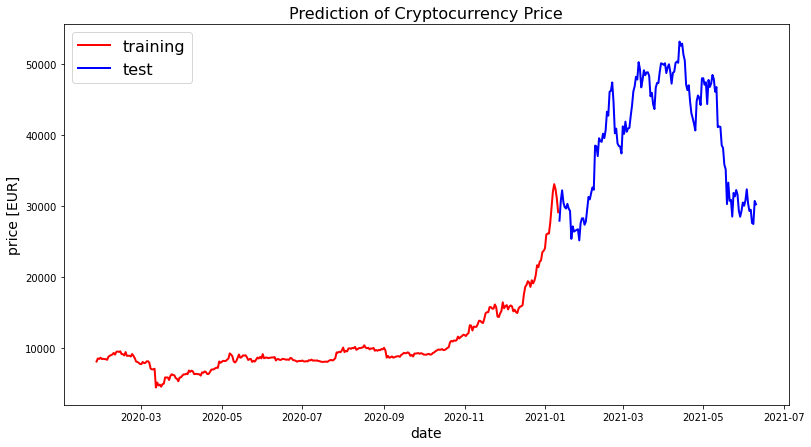

In [44]:
fig, ax = plt.subplots(1, figsize=(13, 7))
ax.plot(train[target_col], label='training', linewidth=2, color = 'r')
ax.plot(test[target_col], label='test', linewidth=2 , color = 'b')
ax.set_xlabel('date', fontsize=14)
ax.set_ylabel('price [EUR]', fontsize=14)
ax.set_title('Prediction of Cryptocurrency Price', fontsize=16)
ax.legend(loc='best', fontsize=16)

In [33]:
def normalise_zero_base(df):
    return df / df.iloc[0] - 1

In [34]:
def extract_window_data(df, window_len=5, zero_base=True):
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

In [35]:
def prepare_data(df, target_col, window_len, zero_base, test_size):
    train_data, test_data = train_test_split(df, test_size=test_size)
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    y_train = train_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values
    if zero_base:
        y_train = y_train / train_data[target_col][:-window_len].values - 1
        y_test = y_test / test_data[target_col][:-window_len].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test

In [36]:
def build_lstm_model(input_data):
    model = Sequential()
    model.add(LSTM(100, activation='tanh', input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(0.2))
    model.add(Dense(units=1, activation='sigmoid'))
    model.compile(loss='mse', optimizer='adam')
    return model

In [37]:
np.random.seed(42)
window_len = 5
test_size = 0.3
zero_base = True

In [38]:
train_data, test_data, X_train, X_test, y_train, y_test = prepare_data(hist, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)
model = build_lstm_model(X_train)

In [39]:
epochs = 300
batch_size = 32

history = model.fit(X_train, y_train,validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, verbose=1)

Epoch 1/300
11/11 [==============================] - 3s 64ms/step - loss: 0.2338 - val_loss: 0.2192
Epoch 2/300
11/11 [==============================] - 0s 9ms/step - loss: 0.1828 - val_loss: 0.1595
Epoch 3/300
11/11 [==============================] - 0s 10ms/step - loss: 0.1198 - val_loss: 0.0590
Epoch 4/300
11/11 [==============================] - 0s 9ms/step - loss: 0.0327 - val_loss: 0.0113
Epoch 5/300
11/11 [==============================] - 0s 10ms/step - loss: 0.0079 - val_loss: 0.0102
Epoch 6/300
11/11 [==============================] - 0s 9ms/step - loss: 0.0066 - val_loss: 0.0102
Epoch 7/300
11/11 [==============================] - 0s 10ms/step - loss: 0.0075 - val_loss: 0.0102
Epoch 8/300
11/11 [==============================] - 0s 9ms/step - loss: 0.0081 - val_loss: 0.0102
Epoch 9/300
11/11 [==============================] - 0s 11ms/step - loss: 0.0080 - val_loss: 0.0102
Epoch 10/300
11/11 [==============================] - 0s 8ms/step - loss: 0.0063 - val_loss: 0.0102
Epoc

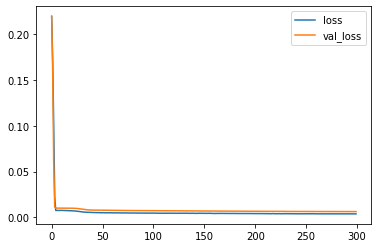

In [40]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()

In [41]:
targets = test_data[target_col][window_len:]
preds = model.predict(X_test).squeeze()
mean_absolute_error(preds, y_test)

0.05973312060391132

**Mean absolute error is 0.059**

In [42]:
preds = test_data[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)

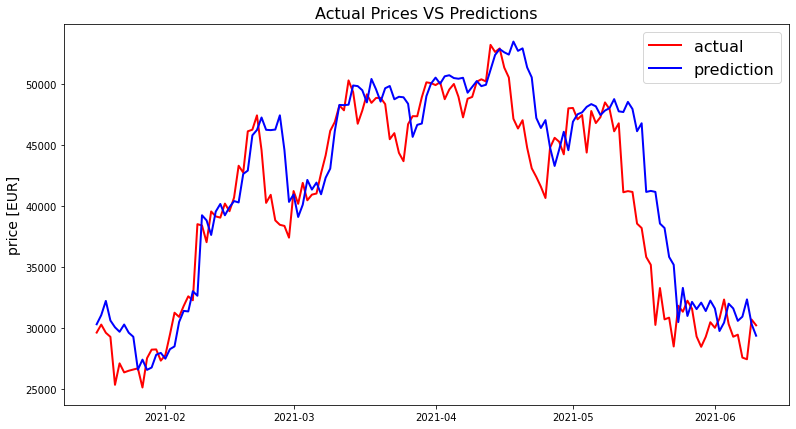

In [45]:
fig, ax = plt.subplots(1, figsize=(13, 7))
ax.plot(targets, label='actual', linewidth=2 , color = 'r')
ax.plot(preds, label='prediction', linewidth=2 , color = 'b')
ax.set_ylabel('price [EUR]', fontsize=14)
ax.set_title('Actual Prices VS Predictions', fontsize=16)
ax.legend(loc='best', fontsize=16)